In [ ]:
!pip install matplotlib
!pip install opencv-python
!pip install numpy
!pip install pillow

In [2]:
import os
import re
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from collections import defaultdict

In [16]:
def ukladka_shift(images, board_width, board_height,
                  canvas_width=7680, canvas_height=7680,
                  shift_step=2, grout_width=2, grout_color=(0, 0, 0, 255)):
    """
    Create a staggered canvas with grout lines between boards
    
    Args:
        images: List of PIL Image objects
        board_width: Width of each board
        board_height: Height of each board
        canvas_width: Output image width
        canvas_height: Output image height
        shift_step: Staggering canvas (2 = brick canvas)
        grout_width: Width of grout lines in pixels
        grout_color: RGBA tuple for grout color
    """
    # Create canvas with transparent background
    canvas_image = Image.new('RGBA', (canvas_width, canvas_height))

    # Create grout image
    grout_horizontal = Image.new('RGBA', (board_width, grout_width), grout_color)
    grout_vertical = Image.new('RGBA', (grout_width, board_height + grout_width), grout_color)

    for col in range(0, canvas_width, board_width + grout_width):
        col_index = col // (board_width + grout_width)

        # Calculate vertical shift
        shift_phase = col_index % shift_step
        vertical_shift = (shift_phase * (board_height + grout_width)) // shift_step
        for row in range(-board_height - grout_width, canvas_height + board_height, board_height + grout_width):
            paste_position = row - vertical_shift

            # Only paste if visible
            if paste_position + board_height > 0 and paste_position < canvas_height:
                # Paste board
                img = random.choice(images)
                img = img.resize((board_width, board_height), Image.Resampling.LANCZOS)
                canvas_image.paste(img, (col, paste_position))

                # Add right grout (except last column)
                canvas_image.paste(grout_vertical, (col + board_width, paste_position))

                # Add bottom grout (except last row)
                canvas_image.paste(grout_horizontal, (col, paste_position + board_height))

    return canvas_image


def ukladka_shift_chaotic(images, board_width, board_height,
                          canvas_width=7680, canvas_height=7680,
                          max_shift_fraction=0.5, min_shift_fraction=0.1, grout_width=1, grout_color=(0, 0, 0, 255)):
    """
    Create a chaotic canvas with each column's shift based on the previous column's shift, within a specified range.
    
    Args:
        images: List of PIL Image objects
        board_width: Width of each board
        board_height: Height of each board
        canvas_width: Output image width
        canvas_height: Output image height
        max_shift_fraction: Maximum random shift as fraction of board height (0-1)
        min_shift_fraction: Minimum random shift as fraction of board height (0-1)
        grout_width: Width of grout lines in pixels
        grout_color: RGBA tuple for grout color
    """
    # Create canvas with transparent background
    canvas_image = Image.new('RGBA', (canvas_width, canvas_height))

    # Create grout images
    grout_horizontal = Image.new('RGBA', (board_width, grout_width), grout_color)
    grout_vertical = Image.new('RGBA', (grout_width, board_height + grout_width), grout_color)

    # Calculate min and max shift values
    min_shift = int(board_height * min_shift_fraction)
    max_shift = int(board_height * max_shift_fraction)

    previous_shift = None  # Track the shift of the previous column

    for col in range(0, canvas_width, board_width + grout_width):
        # Determine vertical shift for this column
        if previous_shift is None:
            # First column: random shift within min/max
            vertical_shift = random.randint(min_shift, max_shift)
        else:
            # Subsequent columns: shift based on previous column's shift
            delta = random.randint(min_shift, max_shift)
            delta *= random.choice([-1, 1])  # Random direction
            new_shift = previous_shift + delta
            if new_shift < 0 or new_shift > board_height:
                new_shift = new_shift % board_height
            vertical_shift = new_shift

        previous_shift = vertical_shift  # Update for next column

        # Iterate over rows with the calculated vertical shift
        for row in range(-board_height - grout_width, canvas_height + board_height, board_height + grout_width):
            paste_position = row - vertical_shift

            # Only paste if visible
            if paste_position + board_height > 0 and paste_position < canvas_height:
                # Randomly choose an image for each board
                img = random.choice(images)
                img = img.resize((board_width, board_height), Image.Resampling.LANCZOS)
                canvas_image.paste(img, (col, paste_position))

                # Add right grout (except last column)
                if col + board_width < canvas_width:
                    canvas_image.paste(grout_vertical, (col + board_width, paste_position))
                # Add bottom grout (except last row)
                if paste_position + board_height < canvas_height:
                    canvas_image.paste(grout_horizontal, (col, paste_position + board_height))

    return canvas_image


def ukladka_elochka(images, board_width, board_height,
                    canvas_width=7680, canvas_height=7680,
                    grout_width=1, grout_color=(0, 0, 0, 255)):
    """
    Create a herringbone (elochka) pattern with proper transparency handling,
    accurate 45-degree angled board placement, and grout between boards.
    
    The grout is added as a border around each board image before rotation,
    so that when boards are placed, a consistent grout gap appears.
    
    Args:
        images: List of PIL Image objects (assumed to be of size board_width x board_height)
        board_width: Width of each board
        board_height: Height of each board
        canvas_width: Output image width
        canvas_height: Output image height
        grout_width: Width of grout lines in pixels (added as border)
        grout_color: RGBA tuple for grout color
    """
    # Create canvas with transparent background
    canvas_image = Image.new('RGBA', (canvas_width, canvas_height))

    angle = 45
    angle_rad = math.radians(angle)
    x_step = int(board_height * math.cos(angle_rad)) + grout_width
    y_step = int(board_width * math.sin(angle_rad)) + grout_width

    # Loop for boards rotated at -45 degrees
    for base_x in range(-x_step, canvas_width, x_step * 2):
        for base_y in range(-8 * y_step, canvas_height, y_step * 2):
            # Choose a random board and convert to RGBA
            img = random.choice(images).convert("RGBA")
            img = img.resize((board_width, board_height), Image.Resampling.LANCZOS)
            # Add grout border around the board
            img_with_grout = ImageOps.expand(img, border=grout_width, fill=grout_color)
            # Rotate image by -45 degrees; expand so the entire image fits
            rotated_img = img_with_grout.rotate(-angle, expand=True)

            pos_x = base_x
            pos_y = base_y

            canvas_image.paste(rotated_img, (pos_x, pos_y), rotated_img)

    # Loop for boards rotated at +45 degrees
    for base_x in range(-x_step, canvas_width, x_step * 2):
        for base_y in range(-8 * y_step, canvas_height, y_step * 2):
            img = random.choice(images).convert("RGBA")
            img = img.resize((board_width, board_height), Image.Resampling.LANCZOS)
            img_with_grout = ImageOps.expand(img, border=grout_width, fill=grout_color)
            rotated_img = img_with_grout.rotate(angle, expand=True)

            pos_x = base_x + x_step
            pos_y = base_y + y_step

            canvas_image.paste(rotated_img, (pos_x, pos_y), rotated_img)

    return canvas_image


In [17]:
def edge_based_crop(img, debug=False, max_offset=20, margin=0):
    """
    Crops images based on edge detection to remove background
    
    Args:
        image_path: Path to input image
        output_path: Path to save result (overwrites original if None)
    """
    if not isinstance(img, np.ndarray):
        img = np.array(img)

    h, w = img.shape[:2]

    # 1. Edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 0, 150)

    # if debug:
    #     cv2.imshow("Edges", edges)
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()

    # 2. Find all edge pixel coords
    ys, xs = np.where(edges > 0)

    # 3. Default to full image if no edges
    if xs.size == 0 and ys.size == 0:
        x_min, x_max = 0, w
        y_min, y_max = 0, h
    else:
        # Handle partial empties
        if xs.size == 0:
            x_min, x_max = 0, w
            y_min = max(ys.min() - margin, 0)
            y_max = min(ys.max() + margin, h)
        elif ys.size == 0:
            y_min, y_max = 0, h
            x_min = max(xs.min() - margin, 0)
            x_max = min(xs.max() + margin, w)
        else:
            x_min = max(xs.min() - margin, 0)
            x_max = min(xs.max() + margin, w)
            y_min = max(ys.min() - margin, 0)
            y_max = min(ys.max() + margin, h)

        # 4. Sanity‐check offsets
        if (x_min > max_offset or
                y_min > max_offset or
                (w - x_max) > max_offset or
                (h - y_max) > max_offset):
            # too far from one of the borders → fallback to full image
            x_min, x_max = 0, w
            y_min, y_max = 0, h

    cropped = img[y_min:y_max, x_min:x_max]

    # Crop and optionally save
    # cropped = img[y:y+h, x:x+w]
    return cropped

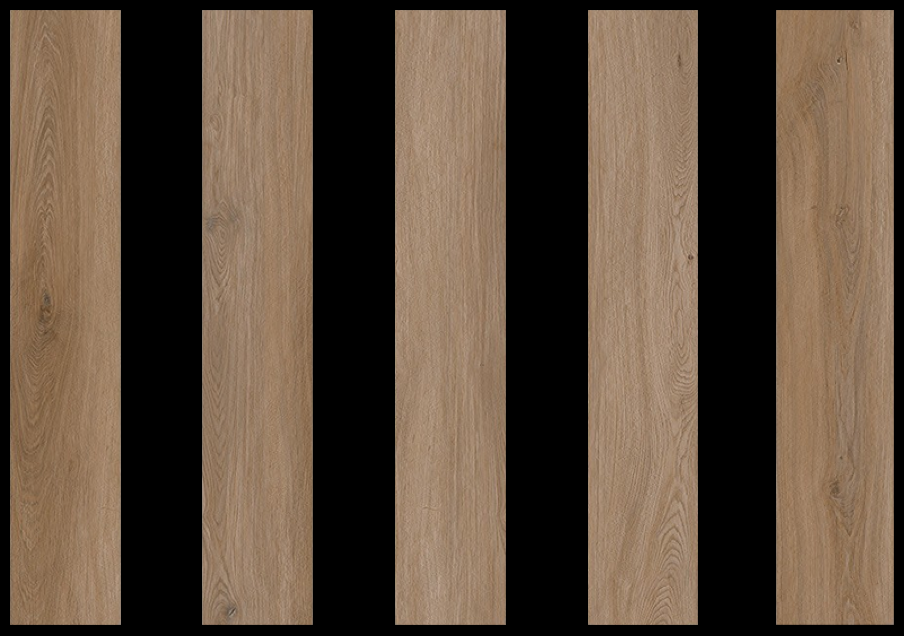

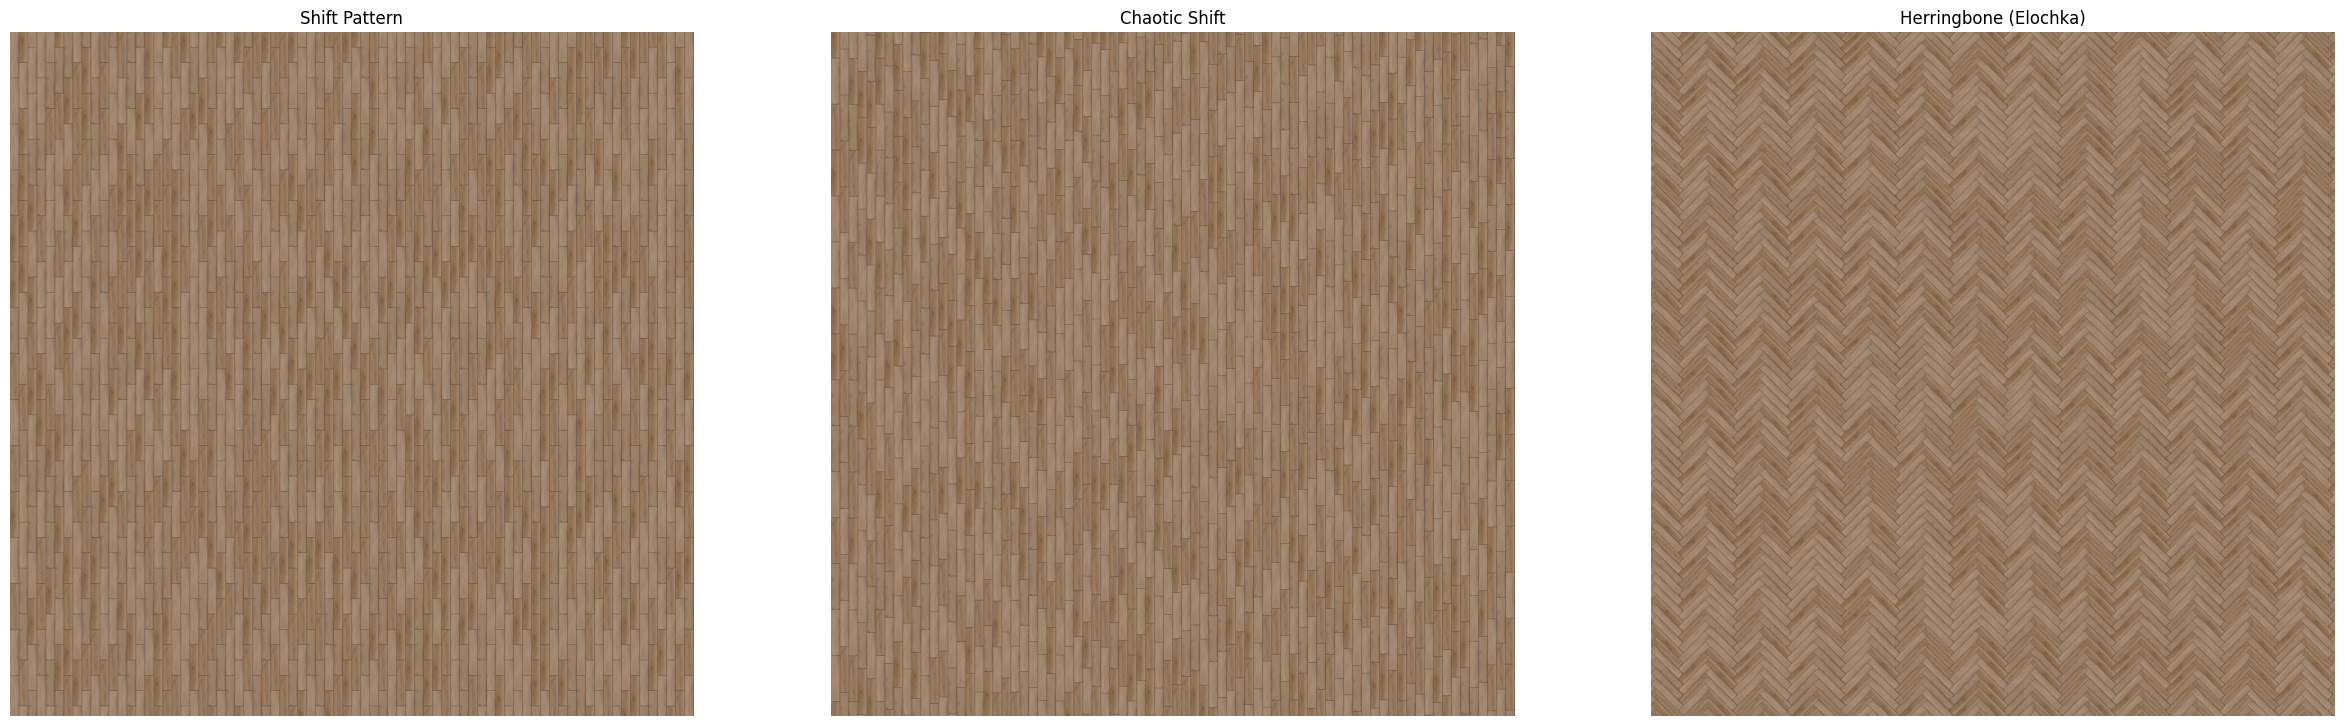

In [20]:
target_width = 100

test_number = 0
folder_path = "data/preprocessed/divided"

boards = defaultdict(list)
pattern = re.compile(r"^(\d{5})_\d\.png$")

# Grouping boards by their names
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        board_type = match.group(1)
        boards[board_type].append(filename)

board_keys = sorted(boards.keys(), key=lambda x: int(x))
groups = [boards[key] for key in board_keys]

for i in range(len(groups)):
    images = []
    #board_group = groups[i] # 66 69 15 23 25
    board_group = groups[0]  # 66 69 15 23 25
    #board_group = random.choice(result)

    fig, ax = plt.subplots(1, len(board_group), facecolor=(0.0, 0.0, 0.0), figsize=(12, 8))

    for board_i, board_name in enumerate(board_group):
        filename = os.path.join(folder_path, board_name)
        with Image.open(filename) as img:
            img.load()
            # Calculate new height maintaining aspect ratio
            width_percent = (target_width / float(img.size[0]))
            new_height = int((float(img.size[1]) * float(width_percent)))
            img = img.resize((target_width, new_height), Image.Resampling.LANCZOS)
            img = Image.fromarray(edge_based_crop(img))
            #img = img.crop((1, 1, target_width, new_height))
        images.append(img)
        ax[board_i].imshow(img)
        ax[board_i].axis('off')

    #plt.show()

    division_factors = [1.0, 2.0, 2.5, 1.8]
    division_factor = division_factors[test_number]

    pattern_shift = ukladka_shift(
        images,
        board_width=int(target_width / division_factor),
        board_height=int(new_height / division_factor),
        grout_width=1,
        grout_color=(0, 0, 0, 255),
        shift_step=3,
    )

    pattern_shift_chaotic = ukladka_shift_chaotic(
        images,
        board_width=int(target_width / division_factor),
        board_height=int(new_height / division_factor),
        grout_width=1,
        grout_color=(0, 0, 0, 255),
    )

    pattern_elochka = ukladka_elochka(
        images,
        board_width=int(target_width / division_factor / 1.2),
        board_height=int(new_height / division_factor / 1.2),
        grout_width=1,
        grout_color=(0, 0, 0, 255),
    )

    pattern_shift.save(f"sborki/pattern_shift_{i}.png")
    pattern_shift_chaotic.save(f"sborki/pattern_shift_chaotic_{i}.png")
    pattern_elochka.save(f"sborki/pattern_elochka_{i}.png")
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    # Display the first pattern
    axes[0].imshow(pattern_shift)
    axes[0].axis('off')
    axes[0].set_title('Shift Pattern')

    # Display the chaotic pattern
    axes[1].imshow(pattern_shift_chaotic)
    axes[1].axis('off')
    axes[1].set_title('Chaotic Shift')

    # Display the herringbone (elochka) pattern
    axes[2].imshow(pattern_elochka)
    axes[2].axis('off')
    axes[2].set_title('Herringbone (Elochka)')

    plt.show()

    break

In [21]:
pattern_shift.save("pattern_shift.png")
pattern_shift_chaotic.save("pattern_shift_chaotic.png")
pattern_elochka.save("pattern_elochka.png")